In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import random
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img

In [2]:
train_dir = "chest_xray/train"
test_dir = "chest_xray/test"
valid_dir = "chest_xray/val"

In [3]:
alltype = ["NORMAL","PNEUMONIA"]
normal = random.sample(os.listdir(train_dir+"/NORMAL"),5)
pneumonia = random.sample(os.listdir(train_dir+"/PNEUMONIA"),5)

In [4]:
from tqdm import tqdm
import cv2
x_train =[]
y_train = []
#os.chdir = "/kaggle/input/chest-xray-pneumonia/chest_xray/train/NORMAL"
for i in tqdm(os.listdir("chest_xray/train/NORMAL")):
    img = cv2.imread("chest_xray/train/NORMAL" +"/"+i)
    img = cv2.resize(img,(256,256))
    x_train.append(img)
    y_train.append("Normal")


100%|██████████| 1341/1341 [00:50<00:00, 26.59it/s]


In [5]:
for i in tqdm(os.listdir("chest_xray/train/PNEUMONIA")):
    img = cv2.imread("chest_xray/train/PNEUMONIA" +"/"+i)
    img = cv2.resize(img,(256,256))
    x_train.append(img)
    y_train.append("PNEUMONIA")

100%|██████████| 3875/3875 [01:03<00:00, 60.99it/s]


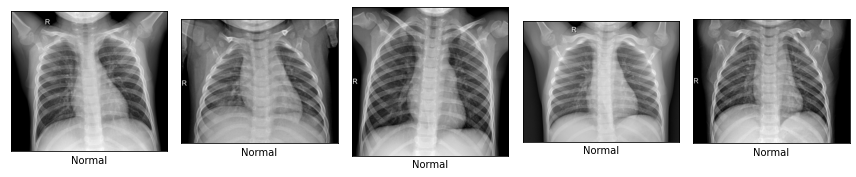

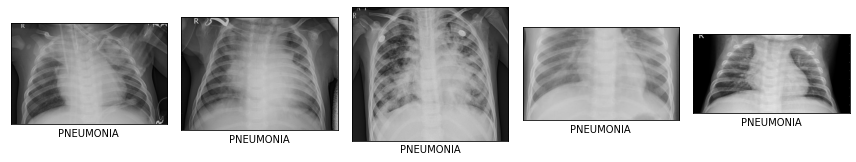

In [6]:
fig = plt.figure(figsize=(12,6))
fig.set_size_inches(12,12)

for i,image in enumerate(normal):
    plt.subplot(1,5,i+1)
    img = load_img(train_dir+"/NORMAL"+"/"+image)
    plt.imshow(img)
    plt.xlabel("Normal")
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()

plt.figure(figsize=(12,6))
fig.set_size_inches(12,12)

for i,image in enumerate(pneumonia):
    plt.subplot(1,5,i+1)
    img = load_img(train_dir+"/PNEUMONIA"+"/"+image)
    plt.imshow(img)
    plt.xlabel("PNEUMONIA")
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
    

In [7]:
print("Total images in Train directory: {}".format(len(os.listdir(train_dir+"/NORMAL")) + len(os.listdir(train_dir+"/PNEUMONIA"))))
print("Total images in Test directory: {}".format(len(os.listdir(test_dir+"/NORMAL")) + len(os.listdir(test_dir+"/PNEUMONIA"))))
print("Total images in Validation directory: {}".format(len(os.listdir(valid_dir+"/NORMAL")) + len(os.listdir(valid_dir+"/PNEUMONIA"))))

Total images in Train directory: 5216
Total images in Test directory: 624
Total images in Validation directory: 16


In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=(1./255),shear_range = 0.2,zoom_range=0.3,
                                horizontal_flip=True)#fill_mode='nearest'
test_datagen = ImageDataGenerator(rescale = (1./255))

train_data = train_datagen.flow_from_directory(directory = train_dir,target_size=(224,224),
                                               class_mode = "categorical",batch_size=32)
test_data = test_datagen.flow_from_directory(directory = test_dir,target_size=(224,224),
                                                class_mode = "categorical",batch_size=32)


Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [9]:
from tensorflow.keras.applications.vgg19 import VGG19
vgg = VGG19(weights = "imagenet",include_top = False,input_shape=(224,224,3))

In [10]:
for layer in vgg.layers:
    layer.trainable = False

In [11]:
from tensorflow.keras.layers import Flatten,Dense,Dropout,BatchNormalization
x = vgg.output
x = Flatten()(x)
x = Dense(units=512, activation='relu')(x)
#x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(units=64, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(2,activation= "sigmoid")(x)

In [12]:
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

model = Model(inputs = vgg.input,outputs = predictions)
model.compile(optimizer="adam",loss = "binary_crossentropy",metrics =["accuracy"])#Adam(1e-4)

In [13]:
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping

checkpoint = ModelCheckpoint("vgg19.h5",monitor = "val_accuracy",save_best_only=True,
                             save_weights_only=False,mode='auto',verbose=1,period=1)

earlystop = EarlyStopping(monitor="val_accuracy",patience=5,verbose=1)

In [14]:
history = model.fit_generator(generator = train_data,validation_data = test_data,
                              epochs = 3,verbose = 1,callbacks=[checkpoint,earlystop])#steps_per_epoch = len(train_datagen),validation_steps = len(val_datagen)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/3
163/163 [==============================] - ETA: 0s - loss: 0.4232 - accuracy: 0.8485
Epoch 00001: val_accuracy improved from -inf to 0.83814, saving model to vgg19.h5
163/163 [==============================] - 232s 1s/step - loss: 0.4232 - accuracy: 0.8485 - val_loss: 0.3912 - val_accuracy: 0.8381
Epoch 2/3
163/163 [==============================] - ETA: 0s - loss: 0.2278 - accuracy: 0.9095
Epoch 00002: val_accuracy improved from 0.83814 to 0.86859, saving model to vgg19.h5
163/163 [==============================] - 191s 1s/step - loss: 0.2278 - accuracy: 0.9095 - val_loss: 0.4507 - val_accuracy: 0.8686
Epoch 3/3
163/163 [==============================] - ETA: 0s - loss: 0.1947 - accuracy: 0.9239
Epoch 00003: val_accuracy improved from 0.86859 to 0.89263, saving model to vgg19.h5
163/163 [==============================] - 228s 1s/step - loss: 0.1947 - accuracy: 0.9239 - val_loss: 0.2889 - val_accuracy

In [26]:
model.save('best_transfer_cnn.h5')

In [27]:
import tensorflow as tf
model = tf.keras.models.load_model('best_transfer_cnn.h5')

In [28]:
model.evaluate_generator(test_data) #val_datagen

[0.2888825833797455, 0.8926281929016113]

In [29]:
x_test =[]
y_test = []
for i in tqdm(os.listdir("chest_xray/test/NORMAL")):
    img = cv2.imread("chest_xray/test/NORMAL" +"/"+i)
    img = cv2.resize(img,(224,224))
    x_test.append(img)
    y_test.append("Normal")
    
for i in tqdm(os.listdir("chest_xray/test/PNEUMONIA")):
    img = cv2.imread("chest_xray/test/PNEUMONIA" +"/"+i)
    img = cv2.resize(img,(224,224))
    x_test.append(img)
    y_test.append("PNEUMONIA")

100%|██████████| 390/390 [00:03<00:00, 98.42it/s]


In [30]:
x_test = np.array(x_test)
y_test = np.array(y_test)

y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred,axis=1)

In [31]:
y_pred[:15]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

In [32]:
unique,counts = np.unique(y_pred,return_counts=True)
print(unique,counts)

[0 1] [335 289]


In [33]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_test = le.fit_transform(y_test)

In [34]:
unique,counts = np.unique(y_test,return_counts=True)
print(unique,counts)

[0 1] [234 390]


In [35]:
from sklearn.metrics import accuracy_score,classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.64      0.91      0.75       234
           1       0.93      0.69      0.79       390

    accuracy                           0.77       624
   macro avg       0.78      0.80      0.77       624
weighted avg       0.82      0.77      0.77       624



(<Figure size 576x576 with 1 Axes>,
 <AxesSubplot:xlabel='predicted label', ylabel='true label'>)

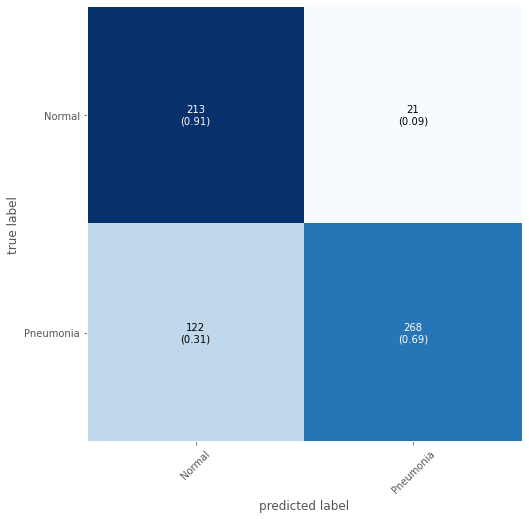

In [36]:
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
cm = confusion_matrix(y_test,y_pred)
plot_confusion_matrix(conf_mat = cm,figsize=(8,8),class_names = ["Normal","Pneumonia"],show_normed=True)

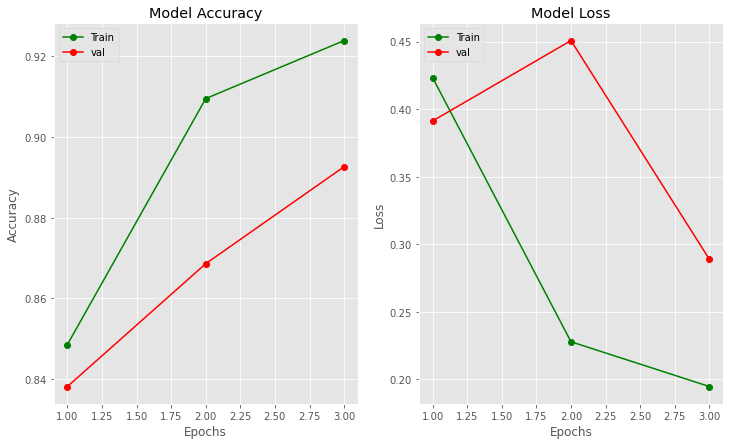

In [38]:
plt.style.use("ggplot")
fig = plt.figure(figsize=(12,7))
epochs = range(1,4)
plt.subplot(1,2,1)
plt.plot(epochs,history.history["accuracy"],"go-")
plt.plot(epochs,history.history["val_accuracy"],"ro-")
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Train","val"],loc = "upper left")
#plt.show()

#fig = plt.figure(figsize=(12,8))    
plt.subplot(1,2,2)
plt.plot(epochs,history.history["loss"],"go-")
plt.plot(epochs,history.history["val_loss"],"ro-")
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Train","val"],loc = "upper left")
plt.show()

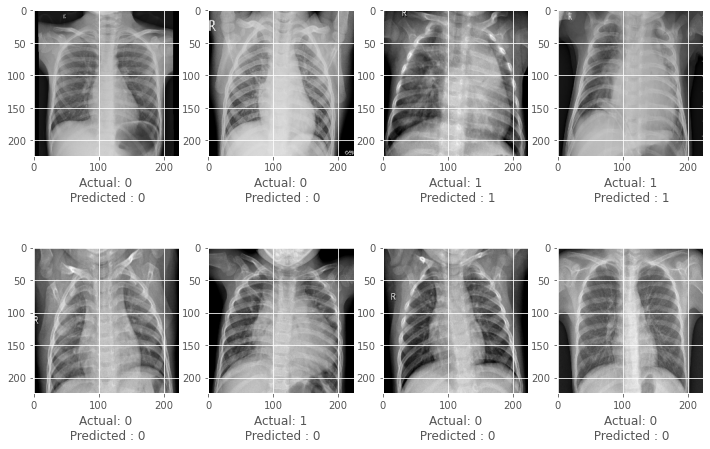

In [39]:
plt.figure(figsize=(12,8))
#plt.title("0 for Normal & 1 is for Pneumonia")
for i in range(8):
    sample_index = np.random.randint(1,len(y_test))
    plt.subplot(2,4,i+1)
    plt.imshow(x_test[sample_index])
    plt.xlabel("Actual: {}\n Predicted : {}".format(y_test[sample_index],y_pred[sample_index]))